In [0]:
'''
PRUNER
'''


!pip install -q torch torchvision numpy

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from collections import OrderedDict
import itertools

'''
class Adder(nn.Module):
  def __init__(self, model, thres = 0.4, function = "var"):
        super(Adder, self).__init__()
        self.model = model
        self.to_add = {}
        self.next_layer = {}
        self.thres = thres
        self.to_train = True #true is train, false is test
        
        layer_names = list(model.pruning_layers._modules.keys())
        for i, layer_name in enumerate(layer_names):
            layer = model.pruning_layers._modules.get(layer_name)
            if(i < len(model.pruning_layers._modules)-1):
                layer.layer_name = layer_name
                self.next_layer[layer_name] = \
                    model.pruning_layers._modules.get(layer_names[i+1])
                if(function == "var" ): #and not to_train
                    layer.register_forward_hook(self.low_variance_nodes)
                
            i += 1
          
          
  def add(self):
      i = 0
      for layer_name, seq_layer in model.pruning_layers._modules.items():
        if(i < len(model.pruning_layers._modules)-1):
          layer = seq_layer._modules['0']
          #print("adding nodes ", layer_name, " ", self.to_add)
          nodes_to_add = self.to_add[layer_name]
          np_weights = layer.weight.data.cpu().numpy()
          #print(np_weights.shape)
          #print(np_weights)
          np_weights = np.concatenate((np_weights, np_weights[nodes_to_add,:, :, :]), axis = 0)
          #print(np_weights.shape)
          layer.weight = Parameter(torch.from_numpy(np_weights).cuda())
          
          num_nodes_to_add = len(nodes_to_add)
          # increment out features
          layer.out_channels += num_nodes_to_add
          
          # increment in features of next layer
          next_layer = self.next_layer[layer_name]
          next_layer = next_layer._modules['0']
          next_layer.in_channels += num_nodes_to_add
          
          bias_weights = layer.bias.data.cpu().numpy()
          #print("bias weights", bias_weights.shape)
          #print(bias_weights)
          #bias_weights = np.stack([bias_weights, bias_weights[nodes_to_add,:, :, :]], axis = 0)
          bias_weights = np.concatenate((bias_weights, bias_weights[nodes_to_add]))
          #print("bias after stack", bias_weights.shape)
          layer.bias = Parameter(torch.from_numpy(bias_weights).cuda())
          
          # add dimension to kernels
          np_weights = next_layer.weight.data.cpu().numpy()
          #np_weights = np.stack([np_weights, np_weights[:,nodes_to_add,:,:]], axis = 1)
          np_weights = np.concatenate((np_weights, np_weights[:, nodes_to_add, :, :]), axis = 1)
          next_layer.weight = Parameter(torch.from_numpy(np_weights).cuda())  
          
          #update batch layer
          batch_layer = seq_layer._modules['3']
          
          #print("before batch layer", batch_layer)
          #print("before running mean", batch_layer.running_mean.shape)
          #print("before weights", batch_layer.weight.shape)
          #print("before bias", batch_layer.bias.shape)
          
          running_mean = batch_layer.running_mean.data.cpu().numpy()
          running_mean = np.concatenate((running_mean, running_mean[nodes_to_add]))
          batch_layer.running_mean = torch.from_numpy(running_mean).cuda()
          
          batch_weight = batch_layer.weight.data.cpu().numpy()
          batch_weight = np.concatenate((batch_weight, batch_weight[nodes_to_add]))
          batch_layer.weight = Parameter(torch.from_numpy(batch_weight).cuda())
          
          batch_bias = batch_layer.bias.data.cpu().numpy()
          batch_bias = np.concatenate((batch_bias, batch_bias[nodes_to_add]))
          batch_layer.bias = Parameter(torch.from_numpy(batch_bias).cuda())
          
          running_var = batch_layer.running_var.data.cpu().numpy()
          running_var = np.concatenate((running_var, running_var[nodes_to_add]))
          batch_layer.running_var = torch.from_numpy(running_var).cuda()
          
          #print("after batch layer", batch_layer)
          #print("after running mean", batch_layer.running_mean.shape)
          #print("after weights", batch_layer.weight.shape)
          #print("after bias", batch_layer.bias.shape)
        i+=1
       
          
  def forward(self, x):
        return self.model(x)
          
    
  def low_variance_nodes(self, layer, input, output):
      #if(not self.to_train):
        #print("low variance hook")
        h, w = output.shape[2], output.shape[3]
        # get correlations
        #n_filters = output.shape[1]
        #print(layer, " ", output)
        layer_vars = np.apply_over_axes(np.var, output.cpu().detach().numpy(), [0,2,3])
        #print("layer vars", layer_vars.ravel())
        layer_vars = np.abs(layer_vars)
        self.to_add[layer.layer_name] = np.where((layer_vars.ravel() < self.thres))[0]
 '''       
            
class Pruner(nn.Module):
    def __init__(self, model, thres = 0.95, function="corrs"):
        super(Pruner, self).__init__()
        self.model = model
        self.to_remove = {}
        self.next_layer = {}
        self.thres = thres
        self.to_train = True #true is train, false is test

        layer_names = list(model.pruning_layers._modules.keys())
        for i, layer_name in enumerate(layer_names):
            layer = model.pruning_layers._modules.get(layer_name)
            if(i < len(model.pruning_layers._modules)-1):
                layer.layer_name = layer_name
                self.next_layer[layer_name] = \
                    model.pruning_layers._modules.get(layer_names[i+1])
                if(function == "corrs"):
                    layer.register_forward_hook(self.correlations)
                elif(function == "l1"):
                    layer.register_forward_hook(self.min_L1)
            i += 1
    
    def prune(self):
        i = 0
        for layer_name, seq_layer in model.pruning_layers._modules.items():
            if(i < len(model.pruning_layers._modules)-1):
                print("remove from ", layer_name, " ", self.to_remove)
                nodes_to_remove = self.to_remove[layer_name]
                n_remove = len(nodes_to_remove)

                layer = seq_layer._modules['0']
                layer.out_channels -= n_remove

                # delete layer_index row in layer, and column in next layer
                np_weights = layer.weight.data.cpu().numpy()
                np_weights = np.delete(np_weights, nodes_to_remove, axis=0)
                layer.weight = Parameter(torch.from_numpy(np_weights).cuda())

                layer_weights = layer.bias.data.cpu().numpy()
                layer_weights = np.delete(layer_weights, nodes_to_remove)
                layer.bias = Parameter(torch.from_numpy(layer_weights).cuda())

                next_layer = self.next_layer[layer_name]._modules['0']
                next_layer.in_channels -= 1
                np_weights = next_layer.weight.data.cpu().numpy()
                np_weights = np.delete(np_weights, nodes_to_remove, axis=1)
                next_layer.weight = Parameter(torch.from_numpy(np_weights).cuda())
                
                for j, module in seq_layer._modules.items():
                  if(type(module) is nn.BatchNorm2d):
                    batch_layer = module
                
                    running_mean = batch_layer.running_mean.data.cpu().numpy()
                    running_mean = np.delete(running_mean, nodes_to_remove)
                    batch_layer.running_mean = torch.from_numpy(running_mean).cuda()

                    batch_weight = batch_layer.weight.data.cpu().numpy()
                    batch_weight = np.delete(batch_weight, nodes_to_remove)
                    batch_layer.weight = Parameter(torch.from_numpy(batch_weight).cuda())

                    batch_bias = batch_layer.bias.data.cpu().numpy()
                    batch_bias = np.delete(batch_bias, nodes_to_remove)
                    batch_layer.bias = Parameter(torch.from_numpy(batch_bias).cuda())

                    running_var = batch_layer.running_var.data.cpu().numpy()
                    running_var = np.delete(running_var, nodes_to_remove)
                    batch_layer.running_var = torch.from_numpy(running_var).cuda()
                i += 1
    
    
    def forward(self, x):
        #print("shape of x ", x.shape)
        return self.model(x)
    
    def pairs_of_low_correlations(self, layer, input, output):
      if(not self.to_train):
        h, w = output.shape[2], output.shape[3]
        # get correlations
        n_filters = output.shape[1]
        corrs = np.zeros((n_filters, n_filters))
        for i in range(h):
            for j in range(w):
                ap = output[:,:,i,j]
                corrs += np.corrcoef(ap.detach().cpu().numpy().T)
        corrs /= n_filters

        # find filter pairs above correlation threshold
        corrs = np.abs(corrs)
        np.fill_diagonal(corrs, 0)
        sorted_corr = np.sort(corrs.ravel())

        nodes_to_prune = np.where((self.thres <= corrs[:,:]))
        rows, cols = nodes_to_prune[0], nodes_to_prune[1]

        # get filters to remove
        for r in range(0, len(rows)):
            r_i = rows[r]
            if(r_i > -1):
              ind = np.where(cols[r] == rows[:])
              rows[ind] = -1
              ind = np.where(rows[r] == rows[r+1:])
              rows[ind] = -1
        self.to_remove[layer.layer_name] = rows[np.where(rows[:] > -1)]
    
        
    '''
    PRUNING FUNCTIONS
    START HERE
    '''
    def min_L1(self, layer, input, output):
      if(not self.to_train):
        activs = np.abs(input[0].detach().cpu().numpy())
        L1 = np.apply_over_axes(np.sum, activs, [0,2,3])
        L1 = L1.reshape(L1.shape[1])
        self.to_remove[layer.layer_name] = [np.argmin(L1)]

    def correlations(self, layer, input, output):
      if(not self.to_train):
        h, w = output.shape[2], output.shape[3]
        # get correlations
        n_filters = output.shape[1]
        corrs = np.zeros((n_filters, n_filters))
        for i in range(h):
            for j in range(w):
                ap = output[:,:,i,j]
                corrs += np.corrcoef(ap.detach().cpu().numpy().T)
        corrs /= n_filters

        # find filter pairs above correlation threshold
        corrs = np.abs(corrs)
        np.fill_diagonal(corrs, 0)
        sorted_corr = np.sort(corrs.ravel())

        nodes_to_prune = np.where((self.thres <= corrs[:,:]))
        rows, cols = nodes_to_prune[0], nodes_to_prune[1]

        # get filters to remove
        for r in range(0, len(rows)):
            r_i = rows[r]
            if(r_i > -1):
              ind = np.where(cols[r] == rows[:])
              rows[ind] = -1
              ind = np.where(rows[r] == rows[r+1:])
              rows[ind] = -1
        self.to_remove[layer.layer_name] = rows[np.where(rows[:] > -1)]


In [0]:
'''
NET
'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pruning_layers = nn.Sequential(OrderedDict([
            ("Layer1",
                nn.Sequential(
                  nn.Conv2d(3, 64, 5, padding=2),
                  nn.MaxPool2d(2),
                  nn.ReLU(), 
                  nn.BatchNorm2d(64, track_running_stats=True)
                )),
            ("Layer2",
                nn.Sequential(
                  nn.Conv2d(64, 128, 5, padding=2),
                  nn.MaxPool2d(2),
                  nn.ReLU(), 
                  nn.Dropout(0.5)
                )),
            ("Layer3",
                nn.Sequential(
                  nn.Conv2d(128, 256, 5, padding=2),
                  nn.ReLU(), 
                  nn.BatchNorm2d(256, track_running_stats=True)
                )),
              ("Layer4",
                nn.Sequential(
                  nn.Conv2d(256, 256, 5, padding=2),
                  nn.MaxPool2d(2),
                  nn.ReLU(), 
                  nn.Dropout(0.5)
                )),
            ("Layer5",
                nn.Sequential(
                  nn.Conv2d(256, 512, 5, padding=2),
                  nn.ReLU(), 
                  nn.BatchNorm2d(512, track_running_stats=True),
                )),
            ("Layer6",
                nn.Sequential(
                  nn.Conv2d(512, 512, 5, padding=2),
                  nn.MaxPool2d(2),
                  nn.ReLU(), 
                  nn.BatchNorm2d(512, track_running_stats=True),
                  nn.Dropout(0.5)
                )),
            ("Layer7",
                nn.Sequential(
                  nn.Conv2d(512, 512, 5, padding=2),
                  nn.ReLU(), 

                )),
            ("Layer8",
                nn.Sequential(
                  nn.Conv2d(512, 512, 5, padding=2),
                  nn.MaxPool2d(2),
                  nn.ReLU(), 
                  nn.BatchNorm2d(512, track_running_stats=True),
                    nn.Dropout(0.5)
                ))
            ])) 
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.Linear(512, 10)
            
        )

    def forward(self, x):
        #print("in net forward size of x ", x.shape)
        x = self.pruning_layers(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        #print("in net forward x shape ", x.shape)
        return F.log_softmax(x, dim=1)

model = Net()

#pruning_model = Pruner(model, thres = 0.9, function = "corrs")

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #data.unsqueeze_(0)
            #print("in test size of data ", data.shape)
            output = model(data)
            #print("error")
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 1. * correct / len(test_loader.dataset)

torch.manual_seed(1)

device = torch.device("cuda")

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)#, momentum=0.5)

Files already downloaded and verified


In [0]:
'''
TRAINING
'''
import time

epoch_range = 5

for epoch in range(epoch_range):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

pruning_model = Pruner(model, thres = 0.5, function = "var")

pruning_model.to_train = False
t0 = time.time()
acc = test(pruning_model, device, val_loader)
t1 = time.time()
print("testing time", (t1-t0))

'''
print("initial model")
run_flops(model)
pruning_model = Adder(model, thres = 0.5, function = "var")
print("adder model")
run_flops(pruning_model)
pruning_model.to_train = False
t0 = time.time()
acc = test(pruning_model, device, val_loader)
t1 = time.time()
print("testing time", (t1-t0))
'''

#t0 = time.time()
#pruning_model.add()
#t1 = time.time()
#print("adding time", (t1 - t0))

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.347346
Train Epoch: 0 [6400/50000 (13%)]	Loss: 1.959809
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.965600
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.777527
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.836329
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.521036
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.651422
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.363297

Test set: Average loss: 2.2736, Accuracy: 3317/10000 (33%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.386820
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.206549
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.193564
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.061360
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.557031
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.957248
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.616940
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.176710

Test set: Average loss: 1.1310, Accuracy: 5996/10000 (60%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.021465
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.004

'\nprint("initial model")\nrun_flops(model)\npruning_model = Adder(model, thres = 0.5, function = "var")\nprint("adder model")\nrun_flops(pruning_model)\npruning_model.to_train = False\nt0 = time.time()\nacc = test(pruning_model, device, val_loader)\nt1 = time.time()\nprint("testing time", (t1-t0))\n'

In [0]:
#thresholds = np.flip(np.logspace(np.log10(0.5), np.log10(0.95), num=8), axis=0)
#thresholds = np.flip(np.logspace(np.log10(0.8), np.log10(0.95), num=5), axis=0)
thresholds = np.flip(np.logspace(np.log10(0.7), np.log10(0.98), num=10), axis=0)
sacrifice = 0.01
data = [{} for k in range(len(thresholds)*5)]
print(data)


def run_flops(model, val):
  net = model
  batch = torch.cuda.FloatTensor(64, 3, 32, 32)
  model = add_flops_counting_methods(net)
  model.eval().start_flops_count()
  
  out = model(batch)
  data[val]["flops"] = model.compute_average_flops_cost()
  data[val]["params"] = get_model_parameters_number(model, False)

  print('Output shape: {}'.format(list(out.shape)))
  print('Flops:  {}'.format(flops_to_string(model.compute_average_flops_cost())))
  print('Params: ' + get_model_parameters_number(model))
  return out
  
def get_flop_data(model, val):
  out_shape = out.shape
  

def test_acc(model, val):
  val_loader = torch.utils.data.DataLoader(
      datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ])),
      batch_size=64, shuffle=True, **kwargs)
  model.to_train = False
  t0 = time.time()
  acc = test(model, device, val_loader)
  t1 = time.time()
  model.to_train = True
  data[val]["final_time"] = t1 - t0
  data[val]["final_acc"] = acc
  print(data)
  print("Inference time ", t1 - t0)
  print("Accuracy", acc)
  return acc

def retrain(model, val):
  epoch_time = []
  epoch_acc = []
  for epoch in range(epoch_range):
      model.to_train = True 
      train(model, device, train_loader, optimizer, epoch)
      model.to_train = False 
      t0 = time.time()
      acc = test(model, device, test_loader)
      t1 = time.time()
      epoch_time.append(t0-t1)
      epoch_acc.append(acc)
      model.to_train = True
  data[val]["epoch_time"] = epoch_time
  data[val]["epoch_acc"] = epoch_acc
  return test_acc(model, val)

def prune_loop(model, thresholds, sacrifice):
  val = 0
  init_model_acc = test_acc(model, val)
  run_flops(model, val)
  #data = {}
  val+=1
  for thres in thresholds:
    print("***** THRES = ", thres, " *****)")
    new_model = Pruner(model, thres = thres, function = "corrs")
    data[val]["thres"] =  thres
    run_flops(new_model, val)
    new_model.to_train = False
    acc = test(new_model, device, val_loader)
    new_model.prune()
    new_model.to_train = True
    new_model_acc = retrain(new_model, val)
    
    i = 0
    while(new_model_acc <= init_model_acc - sacrifice and i < 3):
      print("--- accuracy drop ", i, " ---")
      data[val]["thres"] =  thres
      val+=1; 
      new_model_acc = retrain(new_model, val)
      #data[val].append(run_flops(new_model, val))
      run_flops(new_model, val)
      i += 1
    
    if(new_model_acc <= init_model_acc - sacrifice):
      return model
    model = new_model.model
    val+=1
    print(data)
    print("Number of parameters", sum(p.numel() for p in model.parameters()))
  return [model, data]

  
#thresholds = np.flip(np.logspace(np.log10(0.5), np.log10(0.95), num=10), axis=0)
#thresholds = np.flip(np.logspace(np.log10(0.8), np.log10(0.95), num=5), axis=0)
sacrifice = 0.01
#thresholds = [0.000001, 0.0000001, 0.00000001]
new_model = prune_loop(model, thresholds, sacrifice)
print(data)    
 

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]

Test set: Average loss: 0.9324, Accuracy: 6891/10000 (69%)

[{'final_time': 10.290159940719604, 'final_acc': 0.6891}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
('Inference time ', 10.290159940719604)
('Accuracy', 0.6891)
Output shape: [64, 10]
Flops:  425.3MMac
Params: 26.0M
('***** THRES = ', 0.98, ' *****)')
Output shape: [64, 10]
Flops:  425.3MMac
Params: 26.0M


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:258: RuntimeWarning: invalid value encountered in less_equal



Test set: Average loss: 0.9324, Accuracy: 6891/10000 (69%)

('remove from ', 'Layer1', ' ', {'Layer3': array([], dtype=int64), 'Layer2': array([], dtype=int64), 'Layer1': array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 14,
       14, 14, 14, 14, 14, 18, 18, 18, 18, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 35, 35, 35, 35, 35, 35, 35, 35, 35, 39, 39, 39, 39, 39, 62,
       62, 62, 62]), 'Layer7': array([], dtype=int64), 'Layer6': array([], dtype=int64), 'Layer5': array([], dtype=int64), 'Layer4': array([], dtype=int64)})
('remove from ', 'Layer2', ' ', {'Layer3': array([], dtype=int64), 'Layer2': array([], dtype=int64), 'Layer1': array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 14,
       14, 14, 14, 14, 14, 18, 18, 18, 18, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 35, 35, 35, 35, 35, 35, 35, 35, 35, 39, 39, 39, 39, 39, 62,
       62, 62, 62]), 'Layer7': array([], dtype=int64), 'Layer6': array([], dtype=int64), 'Layer5': array([], 

In [0]:
'''
SAVE DATA
'''

import pickle
f = open("data_124_3epochs_5thres.pkl", 'w')
pickle.dump(data,f)
print(data)
f.close()

[{'flops': 425296384, 'params': 26141706, 'final_time': 10.290159940719604, 'final_acc': 0.6891}, {'epoch_acc': [0.7208, 0.7096, 0.7152, 0.7164, 0.7207], 'flops': 425296384, 'final_time': 91.26736092567444, 'epoch_time': [-91.5190179347992, -91.58450293540955, -91.61871409416199, -91.53201413154602, -90.98405003547668], 'final_acc': 0.7207, 'params': 26141706, 'thres': 0.98}, {'epoch_acc': [0.6841, 0.6818, 0.6838, 0.6814, 0.6844], 'flops': 418930944, 'final_time': 91.29666113853455, 'epoch_time': [-90.4031732082367, -90.63741183280945, -91.82192611694336, -91.60225701332092, -91.27097797393799], 'final_acc': 0.6844, 'params': 26118760, 'thres': 0.94403832854698}, {'epoch_acc': [0.6553, 0.6513, 0.6516, 0.6503, 0.6522], 'flops': 413036032, 'final_time': 90.12201809883118, 'epoch_time': [-90.78635811805725, -90.71795701980591, -90.59618401527405, -90.69995498657227, -90.30129504203796], 'final_acc': 0.6522, 'params': 26102370, 'thres': 0.9093962915977304}, {'epoch_acc': [0.6522, 0.6468, 0

In [0]:
f = open("data_125_3epochs_10thres_ACTUAL_l1.pkl", 'w')
pickle.dump(data,f)
f.close()

In [0]:
'''
in fear of losing code
'''

'''
PRUNING
'''

thresholds = np.flip(np.logspace(np.log10(0.5), np.log10(0.95), num=5), axis=0)
#thresholds = np.flip(np.logspace(np.log10(0.8), np.log10(0.95), num=5), axis=0)
sacrifice = 0.01
data = [{} for k in range(len(thresholds)*5)]
print(data)


def run_flops(model, val):
  net = model
  #batch = torch.cuda.FloatTensor(64, 1, 28, 28)
  batch = torch.cuda.FloatTensor(64, 3, 32, 32)
  model = add_flops_counting_methods(net)
  model.eval().start_flops_count()
  
  out = model(batch)
  data[val]["flops"] = model.compute_average_flops_cost()
  data[val]["params"] = get_model_parameters_number(model, False)

  print('Output shape: {}'.format(list(out.shape)))
  print('Flops:  {}'.format(flops_to_string(model.compute_average_flops_cost())))
  print('Params: ' + get_model_parameters_number(model))
  return out
  
def get_flop_data(model, val):
  out_shape = out.shape
  

def test_acc(model, val):
  val_loader = torch.utils.data.DataLoader(
      datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ])),
      batch_size=64, shuffle=True, **kwargs)
  model.to_train = False
  t0 = time.time()
  acc = test(model, device, val_loader)
  t1 = time.time()
  model.to_train = True
  data[val]["final_time"] = t1 - t0
  data[val]["final_acc"] = acc
  print(data)
  print("Inference time ", t1 - t0)
  print("Accuracy", acc)
  return acc

def retrain(model, val):
  epoch_time = []
  epoch_acc = []
  for epoch in range(epoch_range):
      model.to_train = True 
      train(model, device, train_loader, optimizer, epoch)
      model.to_train = False 
      t0 = time.time()
      acc = test(model, device, test_loader)
      t1 = time.time()
      epoch_time.append(t0-t1)
      epoch_acc.append(acc)
      model.to_train = True
  data[val]["epoch_time"] = epoch_time
  data[val]["epoch_acc"] = epoch_acc
  return test_acc(model, val)

def prune_loop(model, thresholds, sacrifice):
  val = 0
  init_model_acc = test_acc(model, val)
  run_flops(model, val)
  #data = {}
  val+=1
  for thres in thresholds:
    print("***** THRES = ", thres, " *****)")
    new_model = Pruner(model, thres = thres, function = "corrs")
    data[val]["thres"] =  thres
    #data[val].append(run_flops(new_model, val))
    run_flops(new_model, val)
    new_model.to_train = False
    acc = test(new_model, device, val_loader)
    new_model.prune()
    new_model.to_train = True
    new_model_acc = retrain(new_model, val)
    #data[thres] = [model_out, flops_out]
    #new_model_acc = data[thres][0][0]
    i = 0
    while(new_model_acc <= init_model_acc - sacrifice and i < 3):
      print("--- accuracy drop ", i, " ---")
      data[val]["thres"] =  thres
      val+=1; 
      new_model_acc = retrain(new_model, val)
      #data[val].append(run_flops(new_model, val))
      run_flops(new_model, val)
      i += 1
    
    if(new_model_acc <= init_model_acc - sacrifice):
      return model
    model = new_model.model
    val+=1
    print(data)
    print("Number of parameters", sum(p.numel() for p in model.parameters()))
  return [model, data]
'''
def add_loop(model,thresholds, sacrifice):
  init_model_acc = test_acc(model)

  for thres in thresholds:
    print("***** THRES = ", thres, " *****)")
    new_model = Adder(model, thres = thres, function = "var")
    run_flops(new_model)
    new_model.to_train = False
    acc = test(new_model, device, val_loader)
    new_model.add()
    new_model.to_train = True
    new_model_acc = retrain(new_model)
    
    i = 0
    while(new_model_acc <= init_model_acc - sacrifice and i < 3):
      print("--- accuracy drop ", i, " ---")
      new_model_acc = retrain(new_model)
      i += 1

    if(new_model_acc <= init_model_acc - sacrifice):
      return model
    model = new_model.model
    print("Number of parameters", sum(p.numel() for p in model.parameters()))
  return model
 ''' 
  
thresholds = np.flip(np.logspace(np.log10(0.5), np.log10(0.95), num=10), axis=0)
#thresholds = np.flip(np.logspace(np.log10(0.8), np.log10(0.95), num=5), axis=0)
sacrifice = 0.01
#thresholds = [0.000001, 0.0000001, 0.00000001]
new_model = prune_loop(model, thresholds, sacrifice)
print(data)    
  
  

                                  epoch_acc  \
0                                         0   
1  [0.7208, 0.7096, 0.7152, 0.7164, 0.7207]   
2  [0.6841, 0.6818, 0.6838, 0.6814, 0.6844]   
3  [0.6553, 0.6513, 0.6516, 0.6503, 0.6522]   
4  [0.6522, 0.6468, 0.6515, 0.6527, 0.6537]   
5   [0.6538, 0.6437, 0.6459, 0.654, 0.6524]   
6  [0.6528, 0.6452, 0.6518, 0.6522, 0.6536]   

                                          epoch_time  final_acc  final_time  \
0                                                  0     0.6891   10.290160   
1  [-91.5190179348, -91.5845029354, -91.618714094...     0.7207   91.267361   
2  [-90.4031732082, -90.6374118328, -91.821926116...     0.6844   91.296661   
3  [-90.7863581181, -90.7179570198, -90.596184015...     0.6522   90.122018   
4  [-90.473056078, -90.5748150349, -90.4334819317...     0.6537   92.587802   
5  [-91.723074913, -91.9182970524, -91.6845228672...     0.6524   91.534285   
6  [-91.5033860207, -91.5558819771, -91.639791965...     0.6536   91.4

'\n#params\nplt.figure(1)\nplt.scatter(thres[0:4], params[0:4])\nplt.title("Threshold vs Parameters")\nplt.xlabel("Threshold")\nplt.ylabel("Number of parameters")\n\n#final accuracy\nplt.figure(2)\nplt.scatter(thres[0:4], final_acc[0:4])\nplt.title("Threshold vs Accuracy")\nplt.xlabel("Threshold")\nplt.ylabel("Accuracy")\n\n#final time\nplt.figure(3)\nplt.scatter(thres[0:4], final_time[0:4])\nplt.title("Time (seconds)")\n'

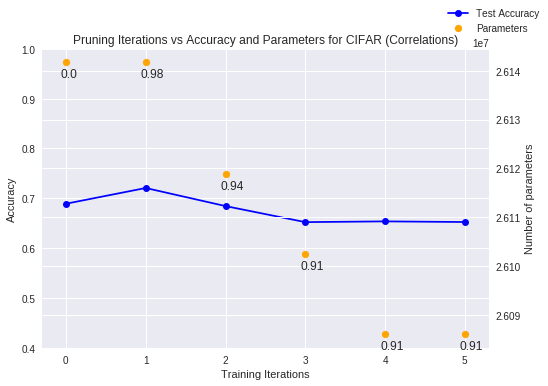

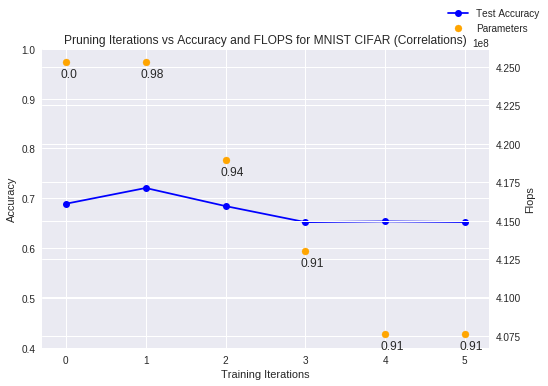

In [0]:
'''
DATA RETRIEVING AND PROCESSING

''' 
import pandas as pd
import pickle 
import matplotlib.pyplot as plt

#unpickled_df = pd.read_pickle("data_125_3epochs_10thres_ACTUAL_l1.pkl")
unpickled_df = pd.read_pickle("data_124_3epochs_5thres_1.pkl")
#print(unpickled_df)

epoch_range = 3

final_data = pd.DataFrame(unpickled_df)
final_data = final_data.dropna(how='all')
final_data = final_data.fillna(0, axis = 1)
print(final_data)


params = final_data['params']
thres = final_data['thres']
final_acc = final_data['final_acc']
final_time = final_data['final_time']
flops = final_data['flops']
print(thres.shape)
#epoch accuracy
epoch_acc = np.array(final_data['epoch_acc'][1:5].values.tolist())
#print(epoch_acc.shape)
plt.figure(0)


fig,ax1 = plt.subplots()
#ax1.set_facecolor('xkcd:white')
#ax1.grid(b=True, which='major', axis='both')
prune_iter = 1
ax2 = ax1.twinx()     
ran = 6
ax1.plot(range(0,ran), final_acc[0:ran], color = "blue", marker = 'o', label = "Test Accuracy")
#ax2.scatter(epoch_range+prune_iter-2, params[i], color = "orange")
ax2.scatter(range(0,ran), params[0:ran], color = "orange", label = "Parameters")
plt.title("Pruning Iterations vs Accuracy and Parameters for CIFAR (Correlations)")
ax1.set_xlabel("Training Iterations")
ax1.set_ylim([0.4, 1.0])
ax1.set_ylabel("Accuracy")
#ax2.set_ylim([16, 26])
ax2.set_ylabel("Number of parameters")
fig.legend()
for i in range(0,ran):
    thr = round(thres[i], 2)
    if(i > 0 and thr == 0):
      thr = round(thres[i-1], 2)
    ax2.annotate(str(thr), (i, params[i]), xytext = (-5, -15), textcoords = 'offset points')


plt.figure()
fig1,ax1 = plt.subplots()
prune_iter = 1
ax2 = ax1.twinx()
ax1.plot(range(0,ran), final_acc[0:ran], color = "blue", marker = 'o', label = "Test Accuracy")
#ax2.scatter(epoch_range+prune_iter-2, params[i], color = "orange")
ax2.scatter(range(0,ran), flops[0:ran], color = "orange", label = "Parameters")
plt.title("Pruning Iterations vs Accuracy and FLOPS for MNIST CIFAR (Correlations)")
ax1.set_xlabel("Training Iterations")
ax1.set_ylim([0.40, 1.0])
ax1.set_ylabel("Accuracy")
#ax2.set_ylim([16000, 26000])
ax2.set_ylabel("Flops")
fig1.legend()

for i in range(0,ran):
    thr = round(thres[i], 2)
    if(i > 0 and thr == 0):
      thr = round(thres[i-1], 2)
    ax2.annotate(str(thr), (i, flops[i]), textcoords = 'offset points', xytext = (-5, -15))

#ax1.legend()

'''
#params
plt.figure(1)
plt.scatter(thres[0:4], params[0:4])
plt.title("Threshold vs Parameters")
plt.xlabel("Threshold")
plt.ylabel("Number of parameters")

#final accuracy
plt.figure(2)
plt.scatter(thres[0:4], final_acc[0:4])
plt.title("Threshold vs Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")

#final time
plt.figure(3)
plt.scatter(thres[0:4], final_time[0:4])
plt.title("Time (seconds)")
'''

In [0]:
final_data.to_csv("data_125_3epochs_10thres_cifar_corr.csv")